In [21]:
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [22]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

identity_scaler = FunctionTransformer(lambda x: x)
# pipeline = Pipeline([
#     ('identity', identity_scaler)
# ])

# # Transform the data
# transformed_data = pipeline.fit_transform(data)

# print(transformed_data)

In [23]:
# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, n: int):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(x_tensor.shape[1], n)
        self.layer2 = nn.Linear(n, n)
        self.layer3 = nn.Linear(n, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.layer1(x))
        x = self.tanh(self.layer2(x))
        x = self.layer3(x)
        return x

class StdNN(nn.Module):
    def __init__(self, n: int):
        super(StdNN, self).__init__()
        self.layer1 = nn.Linear(x_tensor.shape[1], n)
        self.layer2 = nn.Linear(n, n)
        self.layer3 = nn.Linear(n, 1)
        self.tanh = nn.Tanh()
        self.custom_bias = torch.nn.Parameter(torch.tensor([3.0]))

    def forward(self, x):
        x = self.tanh(self.layer1(x))
        x = self.tanh(self.layer2(x))
        x = self.layer3(x)
        x = x + self.custom_bias
        x = torch.sqrt(torch.square(x) + 0.0)
        return x

In [24]:
pinn_base_path = Path('../data_out/3pinn').resolve()

# Load data
# x = np.load(pinn_base_path / 'x.npy')[:500].copy()
# y = np.load(pinn_base_path / 'y.npy')[:500].copy()
pup = Path("../data_out/tmp/3pinn_res_up.npy")
pdown = Path("../data_out/tmp/3pinn_res_down.npy")
x, y = np.load(pup)

# Ensure y is the correct shape for regression (n_samples, 1)
if y.ndim == 1:
    y = y[:, np.newaxis]
if x.ndim == 1:
    x = x[:, np.newaxis]

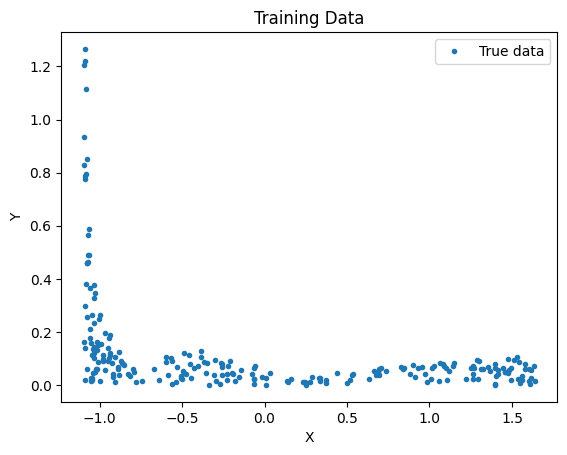

In [25]:
# Plotting the training data
plt.plot(x[:, 0], y, ".", label='True data')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Training Data')
plt.legend()
plt.show()

In [26]:
# Standardize the data
scaler_x = FunctionTransformer()
scaler_y = FunctionTransformer()
x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(y)

# Convert to PyTorch tensors
x_tensor = torch.tensor(x_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

In [27]:
# Instantiate the network, define loss and optimizer
# model = SimpleNN(n=16)
model = StdNN(n=16)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [28]:
# Training the network
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.0298
Epoch [200/1000], Loss: 0.0293
Epoch [300/1000], Loss: 0.0289
Epoch [400/1000], Loss: 0.0285
Epoch [500/1000], Loss: 0.0274
Epoch [600/1000], Loss: 0.0254
Epoch [700/1000], Loss: 0.0238
Epoch [800/1000], Loss: 0.0229
Epoch [900/1000], Loss: 0.0223
Epoch [1000/1000], Loss: 0.0217


In [29]:
model.custom_bias

Parameter containing:
tensor([2.8559], requires_grad=True)

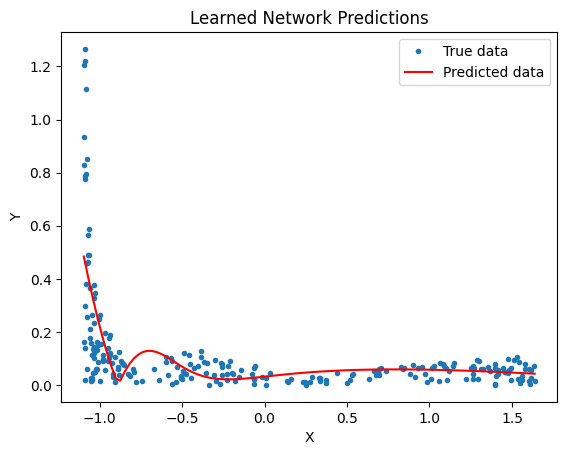

In [30]:
# Plotting the learned network's predictions

xlin = torch.linspace(x_tensor.min(), x_tensor.max(), 100).reshape(-1, 1)
# xlin = torch.from_numpy(np.array(sorted(x_tensor)))

model.eval()
with torch.no_grad():
    y_pred_scaled = model(x_tensor).numpy()
    y_pred_lin_scaled = model(xlin).numpy()
    y_pred_lin = scaler_y.inverse_transform(y_pred_lin_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    xlin = scaler_x.inverse_transform(xlin)

plt.plot(x[:, 0], y, ".", label='True data')
# plt.plot(x[:, 0], y_pred, "x", label='Predicted data', color='red')
plt.plot(xlin[:, 0], y_pred_lin, label='Predicted data', color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Learned Network Predictions')
plt.legend()
plt.show()
